# COMPGC27/MSING055: Programming for Business Analytics

# Group Coursework, Milestone 2

## Team 14
### Team members:  
Mesut Can Alkan  
Lu Wang  
Dimitri Visnadi  
Katerina Klimova  
Alexandros Baltas


Date: 25/11/2016



### Abstract

You will not have one of these yet! It will end up looking like an Executive Summary of your work once you have done it. Sometimes it is useful to write this first, to frame the project in your own head, but it takes practise. 

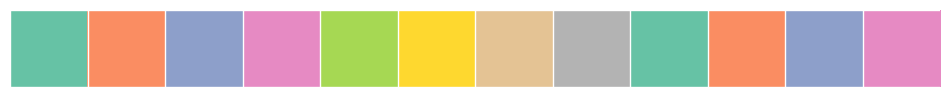

In [3]:
# Authors: A B <contact@email.com> !!! Get into the habit of documenting code so that it is readable 

%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("Set2", 12)
sns.palplot(sns.color_palette())
sns.set_context('talk')

### Business Context: 


Our client is a video game company that produces games for PC. The company has a dataset of competitors’ games reviews at their disposal. This dataset includes reviews of games published for various platforms and their respective genres and release dates.


### Needs: 

The company wishes to expand their business to other platforms as well. As they have never expanded to any other platform and have no relevant experience, they have no sufficient ways of defining which platform they should add into their range.

### Vision:

The marketing department will receive a report on the change of popularity of the gaming platforms over the years.

### Mockup

For a gaming company which did not publish any games for the last 5-6 years, optimal platform and genre to be successful is to release an Action game on the Play Station platform.



### Import publishers

The original dataset did not have the publisher for each game, so the Python code above was used to retrieve the publishers from the website:


In [4]:
import requests
import csv
from html.parser import HTMLParser


class PublisherParser(HTMLParser):

    def __init__(self):
        HTMLParser.__init__(self)
        self.getting_there = False
        self._publisher = None

    def get_publisher(self):
        return self._publisher

    def feed(self, data):
        self.getting_there = False
        self._publisher = None
        HTMLParser.feed(self, data)

    def handle_data(self, data):

        data = data.strip()
        if data == "Publisher":
            self.getting_there = True
        elif data != ":" and self.getting_there:
            self._publisher = data
            self.getting_there = False


class UrlRetriever(object):

    def __init__(self, base):
        self._base_url = base

    def get_base_url(self):
        return self._base_url

    def retrieve(self, url):
        return requests.get(self.get_base_url() + url).text

# --- Uncomment to repeat the process ---
# retriever = UrlRetriever("http://uk.ign.com")
# parser = PublisherParser()

# with open("../data/ign.csv") as f:
#     reader = csv.reader(f, delimiter=',')
#     for row in reader:
#         if row[3] == "url":
#             row.append("Publisher")
#             with open("../data/ign_with_publishers.csv", "w") as g:
#                 writer = csv.writer(g, delimiter=",")
#                 writer.writerow(row)
#         else:
#             parser.feed(retriever.retrieve(row[3]))
#             row.append(parser.get_publisher())
#             with open("../data/ign_with_publishers.csv", "a") as g:
#                 writer = csv.writer(g, delimiter=",")
#                 writer.writerow(row)

### Data
The dataset is imported using pandas.

In [5]:
# Load data into a data frame using pandas
games_df = pd.read_csv("data/ign_with_publishers.csv")
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18625 entries, 0 to 18624
Data columns (total 12 columns):
Unnamed: 0        18625 non-null int64
score_phrase      18625 non-null object
title             18625 non-null object
url               18625 non-null object
platform          18625 non-null object
score             18625 non-null float64
genre             18589 non-null object
editors_choice    18625 non-null object
release_year      18625 non-null int64
release_month     18625 non-null int64
release_day       18625 non-null int64
Publisher         17720 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 1.7+ MB


## Data cleanup

### Missing values

Altough we compiled the data by bringing publisher names using url sources, there were still some missing values for publisher names, and there were missing values for genre also. The rows with missing values are discarded.


In [6]:
games_df = games_df.dropna()
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17687 entries, 0 to 18624
Data columns (total 12 columns):
Unnamed: 0        17687 non-null int64
score_phrase      17687 non-null object
title             17687 non-null object
url               17687 non-null object
platform          17687 non-null object
score             17687 non-null float64
genre             17687 non-null object
editors_choice    17687 non-null object
release_year      17687 non-null int64
release_month     17687 non-null int64
release_day       17687 non-null int64
Publisher         17687 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 1.8+ MB


### Score Phrases

There are eleven different score phrases for the scores ranging from 0 to 10. Masterpiece being 10.0 was followed by Amazing, Great, Good, Okay, Mediocre, Bad, Awful, Painful, Unbearable, Disaster for each point range (e.g 9.0-9.9).


In [7]:
games_df.groupby('score_phrase').score.agg(['mean', 'count']).sort_values("mean")

,mean,count
score_phrase,,
Disaster,0.666667,3
Unbearable,1.272308,65
Painful,2.267485,326
Awful,3.287658,632
Bad,4.333223,1210
Mediocre,5.316865,1850
Okay,6.362283,2768
Good,7.369226,4520
Great,8.316648,4553


There was also one game that the release year is stated as 1970, and it is discarded as well.

In [8]:
games_df = games_df[games_df.release_year > 1970]

### Platform names
Platform names slightly evolved for some categories over the historical period. Such as Play Station, then Play Station 2, Play Station 3, 4, Portable, Vita etc. Consequently, we have mapped again and unified these platform names. For instance, we used Nintendo for all nintendo-related platforms.
We have also unified all ipad, iphone and ipod platform names as these look alike.

### Publisher names
As publisher names may include different company names under the same group, we followed the same methodology as the platform names. For example, Sierra, Sierra Attractions, Sierra On-Line, Sierra Sports, Sierra Studios were all unified due to being part of Sierra Entertainment. So, we applied the same rule to publisher names if they look alike.


In [9]:
games_df = games_df.replace(["Xbox 360", "Xbox One"], "Xbox")
games_df = games_df.replace(["PlayStation", "PlayStation 2", "PlayStation 3", "PlayStation 4","PlayStation Portable", "PlayStation Vita"], "PlayStation")
games_df = games_df.replace(["Nintendo 3DS","Nintendo 64","Nintendo 64DD","Nintendo DS","Nintendo DSi"], "Nintendo")
games_df = games_df.replace(["iPad","iPhone","iPod"], "iOS")
games_df = games_df.replace(["Game Boy","Game Boy Advance","Game Boy Color"], "Game Boy")
games_df = games_df.replace(["WonderSwan","WonderSwan Color"], "WonderSwan")
games_df = games_df.replace(["Wii", "Wii U"], "Wii")
games_df = games_df.replace(["TurboGrafx-16", "TurboGrafx-CD"], "TurboGrafx")
games_df = games_df.replace(["Sega 32X", "Sega CD"], "Sega")
games_df = games_df.replace(["NeoGeo", "NeoGeo Pocket Color"], "NeoGeo")
games_df = games_df.replace(["Dreamcast", "Dreamcast VMU"], "Dreamcast")
games_df = games_df.replace(["Atari 2600", "Atari 5200"], "Atari")


games_df = games_df.replace(["Sierra","Sierra Attractions","Sierra On-Line","Sierra Sports","Sierra Studios"], "Sierra")
games_df = games_df.replace(["Sony BMG Music Entertainment","Sony Computer Entertainment","Sony Online Entertainment","Sony Pictures Entertainment","Sony Pictures Mobile"], "Sony")
games_df = games_df.replace(["Atari","Atari Corp. (1984-2003)","Atari Games"], "Atari")
games_df = games_df.replace(["Namco","Namco Hometek","Namco Networks"], "Namco")
games_df = games_df.replace(["SNK","SNK NeoGeo","SNK Playmore"], "SNK")
games_df = games_df.replace(["Square Enix","Square Enix Collective","Square Enix Mobile"], "Square Enix")
games_df = games_df.replace(["11 Bit Studio","11 Bit Studios"], "11 Bit Studio")
games_df = games_df.replace(["Bandai","Bandai Namco Games"], "Bandai")
games_df = games_df.replace(["Capcom","Capcom Mobile"], "Capcom")
games_df = games_df.replace(["Commodore","Commodore Gaming"], "Commodore")
games_df = games_df.replace(["HeadGames","HeadGames Publishing"], "HeadGames")
games_df = games_df.replace(["Humongous","Humongous Entertainment"], "Humongous")
games_df = games_df.replace(["Intense","Intense Games"], "Intense")
games_df = games_df.replace(["LEGO Interactive","LEGO Media"], "LEGO")
games_df = games_df.replace(["SEGA","SEGA Mobile"], "SEGA")
games_df = games_df.replace(["THQ","THQ Wireless"], "THQ")


### Data Analysis & Visualization

Following the structuring and mapping process, we visualised the data with the number of the games in different platforms over the historical period. We realised that “PlayStation, PC, Xbox, Nintendo, Wii, iOS” were the platforms where satisfying number of games were published for the last ten years. However, there were some cases such as the “Game Boy” platform, where publishing of games was ceased after 2009 despite the large amount of total games published. This increased our interest to focus on these platforms and possibly address one specific platform to promote to the companies which would like to re-enter the gaming industry.

We did the same thing with the genres, and we narrowed the list down to a subset of the genres that are tags to more than 200 games in the dataset.


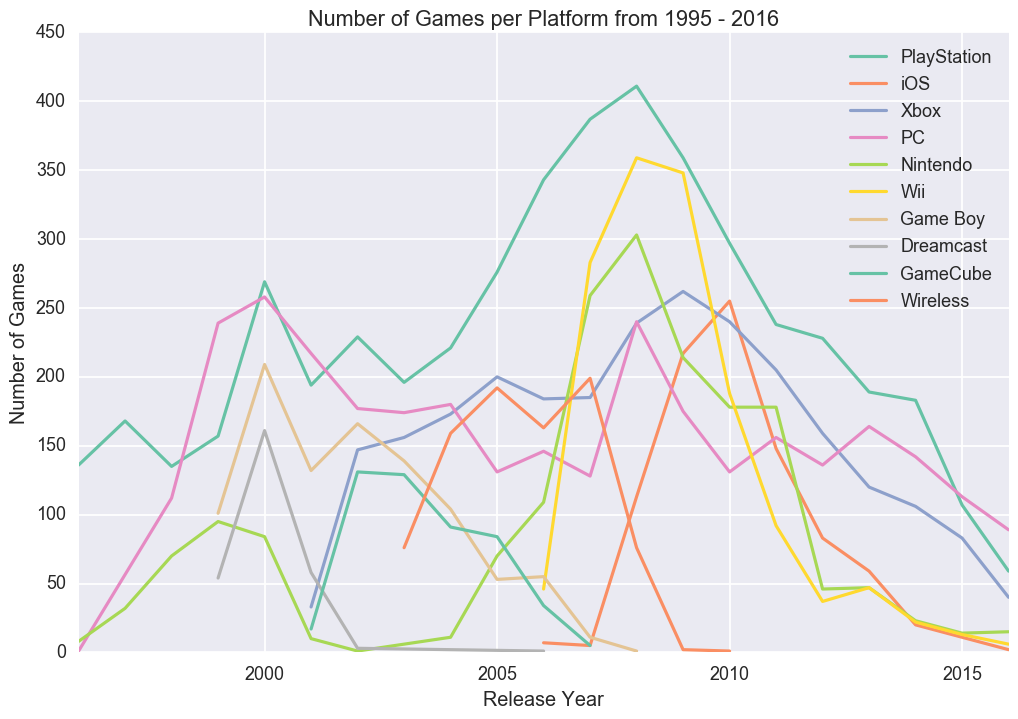

In [10]:
plt.figure(figsize=(12,8))
labels = []
for platform in games_df.platform.unique():  
    temp = games_df[games_df.platform == platform]
    if temp.shape[0] > 200:
        labels.append(platform)
        ax = games_df[games_df.platform == platform].groupby(['release_year']).size().plot()
ax.legend(labels, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Number of Games")
plt.title("Number of Games per Platform from 1995 - 2016")

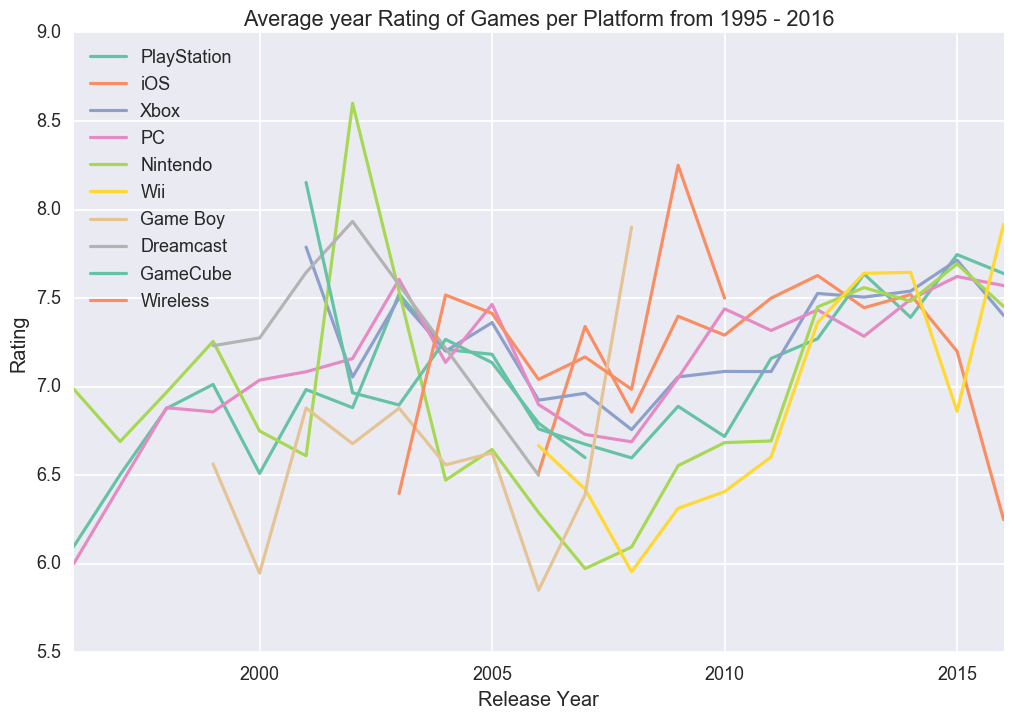

In [11]:
plt.figure(figsize=(12,8))
labels=[]
for platform in games_df.platform.unique():  
    temp = games_df[games_df.platform == platform]
    if temp.shape[0] > 200:
        ax = games_df[games_df.platform == platform].groupby(['release_year']).score.mean().plot()
        labels.append(platform)
ax.legend(labels, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Rating")
plt.title("Average year Rating of Games per Platform from 1995 - 2016")

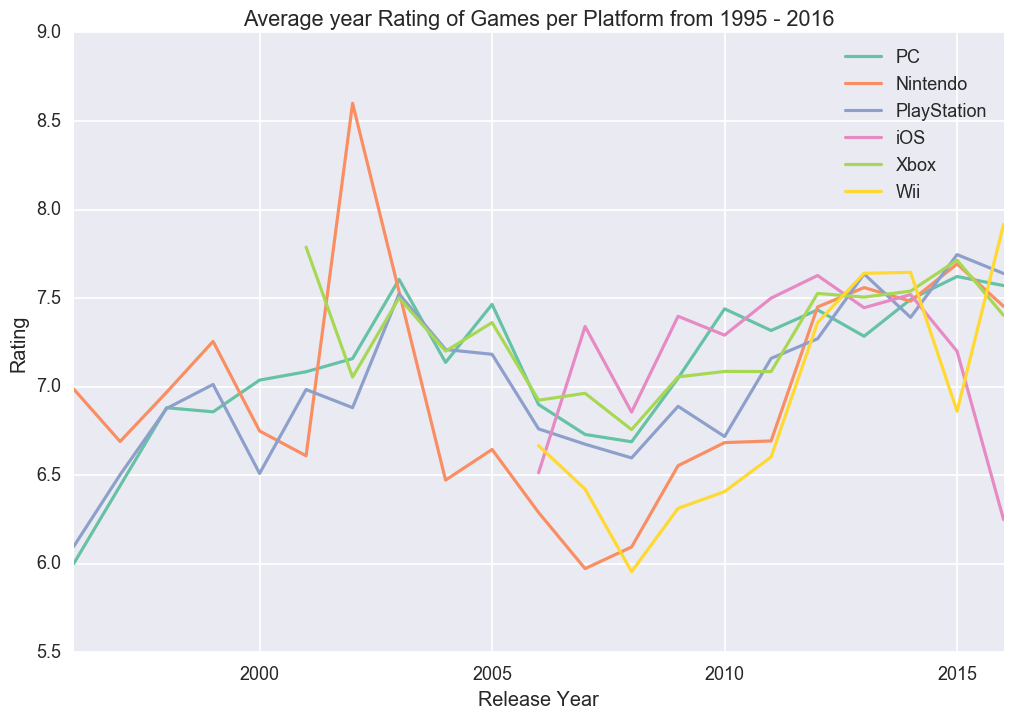

In [12]:
plt.figure(figsize=(12,8))
platfroms_list = ["PC", "Nintendo", "PlayStation", "iOS", "Xbox", "Wii"]
for p in platfroms_list:  
    ax = games_df[games_df.platform == p].groupby(['release_year']).score.mean().plot()
ax.legend(platfroms_list, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Rating")
plt.title("Average year Rating of Games per Platform from 1995 - 2016")

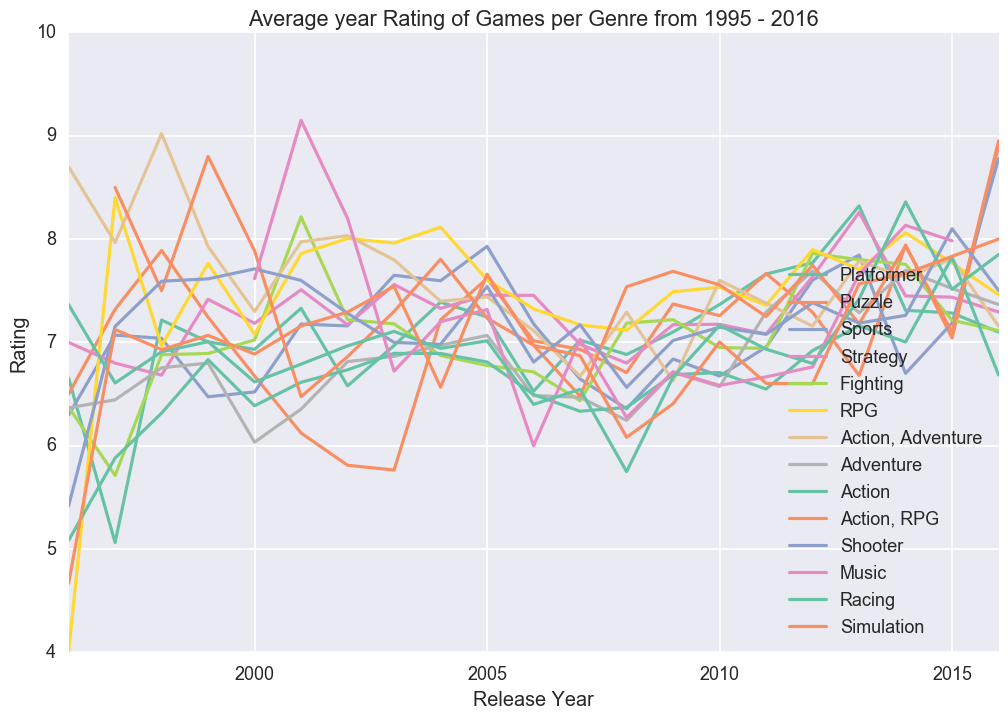

In [13]:
plt.figure(figsize=(12,8))
genres_list=[]
for genre in games_df.genre.unique():  
    temp = games_df[games_df.genre == genre]
    if temp.shape[0] > 200:
        ax = games_df[games_df.genre == genre].groupby(['release_year']).score.mean().plot()
        genres_list.append(genre)
ax.legend(genres_list, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Rating")
plt.title("Average year Rating of Games per Genre from 1995 - 2016")

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


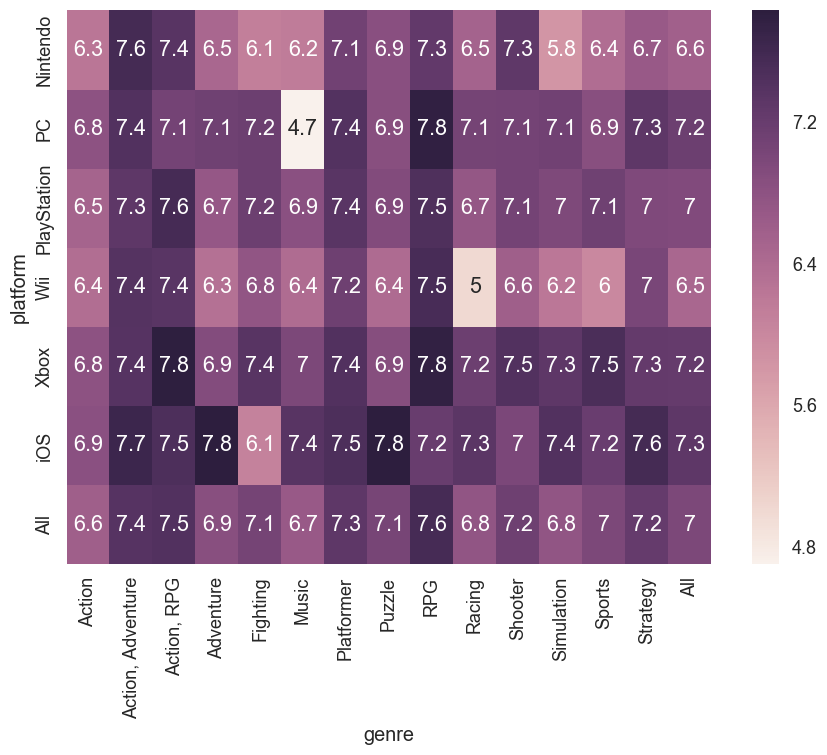

In [14]:
table_avg_score = pd.pivot_table(games_df[games_df.platform.isin(platfroms_list)][games_df.genre.isin(genres_list)]
                                 ,values=['score'],columns=['genre'],index=['platform'],aggfunc=np.average,margins=True)


ax=sns.heatmap(table_avg_score['score'], annot = True)

### Timeline graph of platfom

The platforms in blue are still 'alive' in 2016. (Xbox 360 as a wrong entry what shell we do about that?)

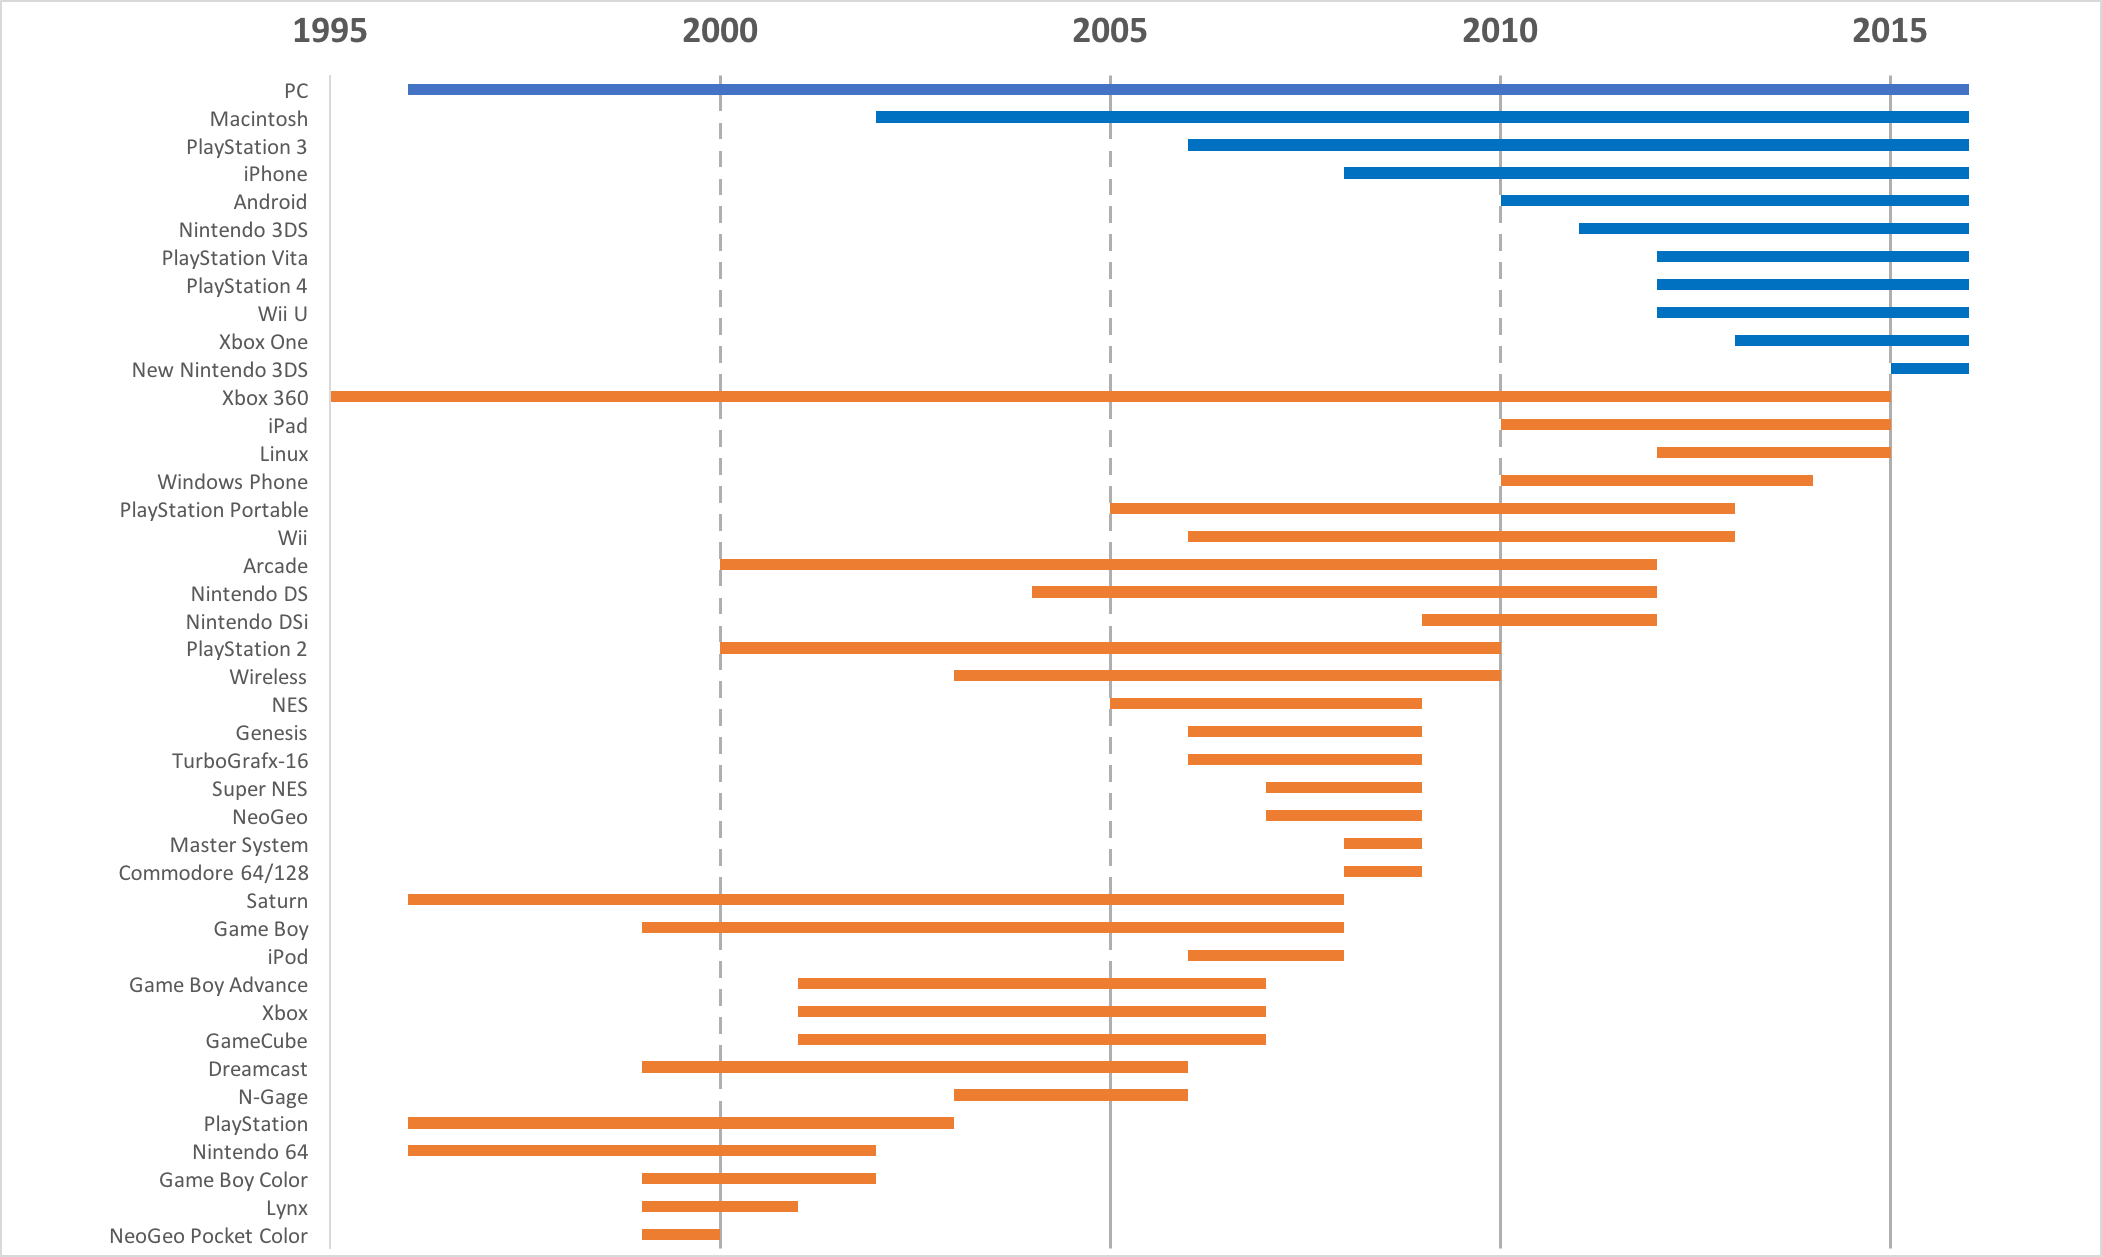

In [84]:
from IPython.display import Image
Image("data/timeline.png")

In [76]:
timeline_df = pd.read_csv("data/ign_with_publishers_timeline.csv")

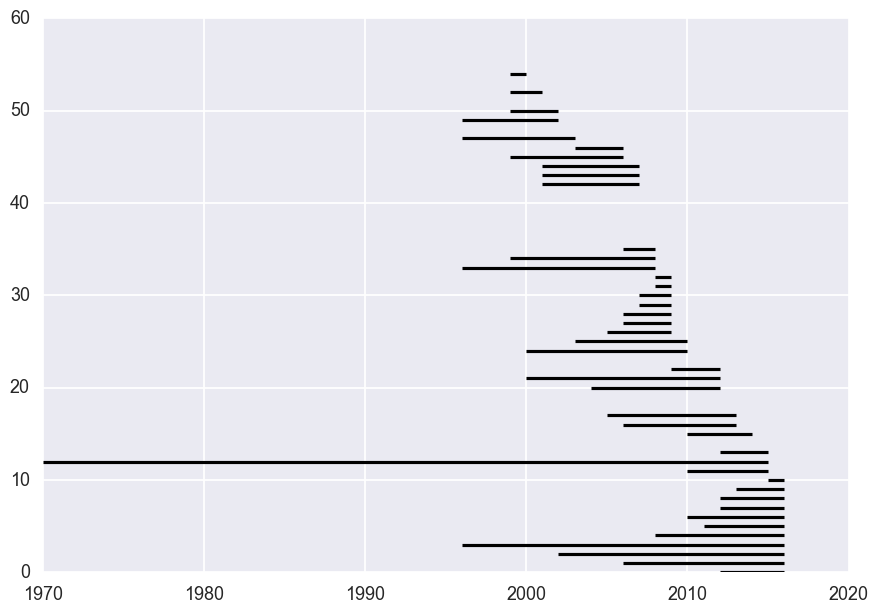

In [83]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dt

timeline_df.amin = timeline_df.release_year_min
timeline_df.amax = timeline_df.release_year_max

fig = plt.figure()
ax = fig.add_subplot(111)
# ax = ax.xaxis_date()
ax = plt.hlines(timeline_df.index, timeline_df.amin, timeline_df.amax)

### Publishers

We compute and display the average score per publisher.

In [48]:
g_per_publisher = []
for publisher,data in games_df.groupby('Publisher'):
    if data.shape[0] >= 50: 
        g_per_publisher.append((publisher,data.score.mean()))
    
g_per_publisher = pd.DataFrame.from_records(g_per_publisher,columns=('publisher','avg_score'))
g_per_publisher = g_per_publisher[g_per_publisher.avg_score > 7.0]
g_per_publisher = g_per_publisher.sort('avg_score',ascending=False)

g_per_publisher

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,publisher,avg_score
40,Rockstar Games,8.463000
51,Telltale Games,7.997516
25,Independent,7.951852
33,Microsoft Game Studios,7.812000
16,Digital Chocolate,7.794643
32,Microsoft,7.666387
38,Nintendo,7.641954
21,Electronic Arts,7.609502
46,Square Enix,7.574786
22,Gameloft,7.567544




## Regression trials

### Results  
According to the data, score was the most important variable to decide whether a game published was successful or not. So we tried to run a regression with score being dependent variable, genre, platform and editor’s choice being independent variables. As we had score ranging from 0 to 10, we create a new dummy score variable of “1” to see if it is greater than 7.9 (which is great, amazing or masterpiece) or “0” to see if it is not so successful. We concluded with a “Pseudo R2” value of 0.0212 which was quite low.
So we ran the regression again, but this time with a score dummy variable of “1” if it is greater than 8.9 (which is amazing or masterpiece) or “0” to see if it is not so successful. This time, we concluded with a “Pseudo R2” value of 0.5304 which was relatively high. 
When we looked at the results of the second regression, we noticed that the odds ratio of editor’s choice was 198.1132 which was extremely significant. Consequently, we ran the second regression without editor’s choice dependent variable to see its effect on the result. We concluded with a “Pseudo R2” value of 0.0267 which was again quite low.


### Findings  
We know that editor’s choice (the most significant variable on the score) was an information generated when a game was published. As we don’t have that information for a game which is yet to be published, we would estimate it for a specific game in specific platform in accordance to the existing data.


### Question  
How about dividing the data into validation and training samples randomly, then estimating editor’s choice for different genre and platform of games to suggest platform and genres to the game companies which did not publish any games for the last 5-6 years?
